# Exploratory Data Analysis of Epicurious Scrape in a JSON file

This is an idealized workflow for Aaron Chen in looking at data science problems. It likely isn't the best path, nor has he rigidly applied or stuck to this ideal, but he wishes that he worked this way more frequently.

## Purpose: Work through some exploratory data analysis of the Epicurious scrape on stream. Try to write some functions to help process the data.

### Author: Aaron Chen


---

### If needed, run shell commands here

In [ ]:
# !python -m spacy download en_core_web_sm
# !python -c "import tkinter"

---

## External Resources

List out references or documentation that has helped you with this notebook

### Code
Regex Checker: https://regex101.com/

#### Scikit-learn
1. https://scikit-learn.org/stable/modules/decomposition.html#latent-dirichlet-allocation-lda
2. 

### Data

For this notebook, the data is stored in the repo base folder/data/raw

### Process

Are there steps or tutorials you are following? Those are things I try to list in Process

___

## Import necessary libraries

In [20]:
from datetime import datetime
# from examples import utils
from joblib import dump, load
import matplotlib.pyplot as plt
from openTSNE import TSNE
import pandas as pd
from sklearn import tree
from sklearn.base import TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import spacy
from tkinter import N
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm
from typing import Any
import umap

ModuleNotFoundError: No module named 'examples'

---

## Define helper functions

My workflow is to try things with code cells, then when the code cells get messy and repetitive, to convert into helper functions that can be called.

When the helper functions are getting used a lot, it is usually better to convert them to scripts or classes that can be called/instantiated

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

In [ ]:
def concat_matrices_to_df(df, vectorized_ingred_matrix, cv):
    """This function takes in a dataframe and concats the matrix generated by either CountVectorizer or TFIDF-Transformer onto the records so that the recipes can be used for classification purposes.

    Args: 
        df: preprocessed dataframe from preprocess_dataframe
        vectorized_ingred_matrix: sparse csr matrix created from doing fit_transform on the recipe_megalist
     
    Returns:
        A pandas dataframe with the vectorized_ingred_matrix appended as columns to df
    """
    repo_tfidf_df = pd.DataFrame(vectorized_ingred_matrix.toarray(), columns=cv.get_feature_names_out(), index=df.index)
    return pd.concat([df, repo_tfidf_df], axis=1)

In [ ]:
def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()

In [ ]:
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

In [ ]:
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

### Import local script

I started grouping this in with importing libraries, but putting them at the bottom of the list

In [2]:
import project_path

import src.dataframe_preprocessor as dfpp
import src.nlp_processor as nlp_proc

---

## Define global variables 
### Remember to refactor these out, not ideal

In [3]:
data_path = "../../data/recipes-en-201706/epicurious-recipes_m2.json"
food_stopwords_path = "../../food_stopwords.csv"

---

## Running Commentary

1. I used numbered lists to keep track of things I noticed

### To Do

1. Try to determine consistency of nested data structures
   1. Is the photoData or number of things inside photoData the same from record to record
   2. What about for tag?

Data wasn't fully consistent but logic in helper function helped handle nulls

2. How to handle nulls?
   1. Author      Filled in with "Missing Author"
   2. Tag         Filled in with "Missing Cuisine"
3. ~~Convert pubDate to actual timestamp~~  
4. ~~Convert ScrapeDate to actual timestamp~~
   1. This was ignored as the datestamp was not useful (generally within minutes of the origin of UNIX time)
   
**5. Append new columns for relevant nested structures and unfold them**

6. Determine actual types of `ingredients` and `prepSteps`
7. Continue working through test example of single recipe to feed into spaCy and then sklearn.feature_extraction.text stack
8. Will need to remove numbers, punctuation

---

## Importing and viewing the data as a dataframe

In [ ]:
sheeeeeesh = pd.read_json(path_or_buf=data_path) # type:ignore
# pd.read_json(data_path, typ='frame') # type:ignore

sheeeeeesh.set_index('id', inplace=True)

letsgoooo = dfpp.preprocess_dataframe(df=sheeeeeesh) # type:ignore

recipe_megalist = [ingred for recipe in letsgoooo['ingredients'].tolist() for ingred in recipe]

nlp = spacy.load("en_core_web_sm")

# this is a redeem for variable naming mixed with a free pun-ish me daddy, flushtrated will be the list of all stopword to exclude so named because we're throwing these words down the drain

flushtrated = {x for x in pd.read_csv(food_stopwords_path)}
additional_to_exclude = {'red', 'green', 'black', 'yellow', 'white', 'inch', 'mince', 'chop', 'fry', 'trim', 'flat', 'beat', 'brown', 'golden', 'balsamic', 'halve', 'blue', 'divide', 'trim', 'unbleache', 'granulate', 'Frank', 'alternative', 'american', 'annie', 'asian', 'balance', 'band', 'barrel', 'bay', 'bayou', 'beam', 'beard', 'bell', 'betty', 'bird', 'blast', 'bob', 'bone', 'breyers', 'calore', 'carb', 'card', 'chachere', 'change', 'circle', 'coffee', 'coil', 'country', 'cow', 'crack', 'cracker', 'crocker', 'crystal', 'dean', 'degree', 'deluxe', 'direction', 'duncan', 'earth', 'eggland', 'ener', 'envelope', 'eye', 'fantastic', 'far', 'fat', 'feather', 'flake', 'foot', 'fourth', 'frank', 'french', 'fusion', 'genoa', 'genovese', 'germain', 'giada', 'gold', 'granule', 'greek', 'hamburger', 'helper', 'herbe', 'hines', 'hodgson', 'hunt', 'instruction', 'interval', 'italianstyle', 'jim', 'jimmy', 'kellogg', 'lagrille', 'lake', 'land', 'laurentiis', 'lawry', 'lipton', 'litre', 'll', 'maid', 'malt', 'mate', 'mayer', 'meal', 'medal', 'medallion', 'member', 'mexicanstyle', 'monte', 'mori', 'nest', 'nu', 'oounce', 'oscar', 'ox', 'paso', 'pasta', 'patty', 'petal', 'pinche', 'preserve', 'quartere', 'ranch', 'ranchstyle', 'rasher', 'redhot', 'resemble', 'rice', 'ro', 'roni', 'scissor', 'scrap', 'secret', 'semicircle', 'shard', 'shear', 'sixth', 'sliver', 'smucker', 'snicker', 'source', 'spot', 'state', 'strand', 'sun', 'supreme', 'tablepoon', 'tail', 'target', 'tm', 'tong', 'toothpick', 'triangle', 'trimming', 'tweezer', 'valley', 'vay', 'wise', 'wishbone', 'wrapper', 'yoplait', 'ziploc'}

flushtrated = flushtrated.union(STOP_WORDS)
flushtrated = flushtrated.union(additional_to_exclude)
flushtrated_list = list(flushtrated)

In [ ]:
custom_nlp_proc = nlp_proc.NLP_Processor("en_core_web_sm")

cv = CountVectorizer(strip_accents='unicode', 
                        lowercase=True, 
                        preprocessor=custom_nlp_proc.custom_preprocessor, 
                        tokenizer=custom_nlp_proc.custom_lemmatizer, 
                        stop_words=flushtrated_list, 
                        token_pattern=r"(?u)\b[a-zA-Z]{2,}\b", 
                        ngram_range=(1,4), 
                        min_df=10
                        )

cv.fit(tqdm(recipe_megalist))

temp = letsgoooo["ingredients"].apply(" ".join).str.lower()

repo_transformed = cv.transform(tqdm(temp))

cv.get_feature_names_out().shape

In [ ]:
tfidf = TfidfTransformer()

repo_tfidf = tfidf.fit_transform(repo_transformed)

repo_tfidf.shape

In [ ]:
recipes_with_cv = concat_matrices_to_df(letsgoooo, repo_tfidf, cv)

We can try to filter out the adjectives in the lemmatization step, because spaCy allows filtering based on Parts of Speech. But this might exclude them from the ngrams. Let's try augmenting stopwords and excluding colors that way.

In [ ]:
filtered_df = recipes_with_cv.drop(['dek', 'hed', 'aggregateRating', 'ingredients', 'prepSteps',
       'reviewsCount', 'willMakeAgainPct', 'photo_filename',
       'photo_credit', 'author_name', 'date_published', 'recipe_url'], axis=1)

filtered_df.head()

In [68]:
reduced_df = filtered_df[filtered_df['cuisine_name'] != 'Missing Cuisine']
reduced_df.set_index('id', inplace=True)
y = reduced_df['cuisine_name']
X = reduced_df.drop(['cuisine_name'], axis=1)

NameError: name 'filtered_df' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=240, stratify=y)

In [ ]:
rfc_clf = RandomForestClassifier(max_depth=50, random_state=572, class_weight="balanced", n_jobs=-1)

rfc_clf.fit(X_train, y_train)
print(rfc_clf.score(X_test, y_test))

In [4]:
joblib_basepath = '../../joblib/2022.08.23/'

cv_path = joblib_basepath + 'countvec.joblib'
tfidf_path = joblib_basepath + 'tfidf.joblib'
full_df_path = joblib_basepath + 'recipes_with_cv.joblib'
reduced_df_path = joblib_basepath + 'reduced_df.joblib'
rfc_path = joblib_basepath + 'rfc_clf.joblib'

In [ ]:
dump(cv, cv_path)
dump(tfidf, tfidf_path)
dump(recipes_with_cv, full_df_path)
dump(reduced_df, reduced_df_path)
dump(rfc_clf, rfc_path)

In [75]:
cv = load(cv_path)
tfidf = load(tfidf_path)
recipes_with_cv = load(full_df_path)
reduced_df = load(reduced_df_path)
reduced_df.set_index('id', inplace=True)
rfc_clf = load(rfc_path)

Sklearn works with DOT formatted trees. ETE does not support this yet. It is a feature being added for ETE milestone 4 but that is as of this stream 50% complete https://github.com/etetoolkit/ete/issues/361

In [76]:
# reduced_df = filtered_df[filtered_df['cuisine_name'] != 'Missing Cuisine']
y = reduced_df['cuisine_name']
X = reduced_df.drop(['cuisine_name'], axis=1)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=240, stratify=y)

In [78]:
X_train.shape

(11124, 3351)

In [79]:
X_train.head()

,achiote,acid,addition,adobo,adobo adobo,adobo adobo sauce,adobo sauce,adobo sauce chipotle,african,agave,...,zest pith,zest vegetable,zinfandel,ziti,zucchini,zucchini blossom,zucchini crookneck,zucchini squash,árbol,árbol pepper
id,,,,,,,,,,,,,,,,,,,,,
54a45bfb6529d92b2c023f25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a4638719925f464b395c16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a441126529d92b2c01b5f2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a409bb19925f464b37380a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54a42e1019925f464b3818d4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
X_train.index

Index(['54a45bfb6529d92b2c023f25', '54a4638719925f464b395c16',
       '54a441126529d92b2c01b5f2', '54a409bb19925f464b37380a',
       '54a42e1019925f464b3818d4', '54a4555f19925f464b391364',
       '54a43aa66529d92b2c019e9f', '54a455ea19925f464b391a6e',
       '54a4577b19925f464b392619', '54a4530e19925f464b38f4d1',
       ...
       '54a479e719925f464b39b2ff', '54a431ae19925f464b384549',
       '54a453c319925f464b38feaf', '54a4091819925f464b37358c',
       '54a434ef6529d92b2c017765', '54a436266529d92b2c018767',
       '54a466e16529d92b2c026f67', '54a451cd6529d92b2c01eefd',
       '54a44e026529d92b2c01d6dd', '54a45aa06529d92b2c02364f'],
      dtype='object', name='id', length=11124)

In [81]:
y_train.index

Index(['54a45bfb6529d92b2c023f25', '54a4638719925f464b395c16',
       '54a441126529d92b2c01b5f2', '54a409bb19925f464b37380a',
       '54a42e1019925f464b3818d4', '54a4555f19925f464b391364',
       '54a43aa66529d92b2c019e9f', '54a455ea19925f464b391a6e',
       '54a4577b19925f464b392619', '54a4530e19925f464b38f4d1',
       ...
       '54a479e719925f464b39b2ff', '54a431ae19925f464b384549',
       '54a453c319925f464b38feaf', '54a4091819925f464b37358c',
       '54a434ef6529d92b2c017765', '54a436266529d92b2c018767',
       '54a466e16529d92b2c026f67', '54a451cd6529d92b2c01eefd',
       '54a44e026529d92b2c01d6dd', '54a45aa06529d92b2c02364f'],
      dtype='object', name='id', length=11124)

In [82]:
we_were_talking_about_variable_name = TruncatedSVD(n_components=100, n_iter=15, random_state=268)
we_were_talking_about_variable_name_svd = we_were_talking_about_variable_name.fit_transform(X_train)

Suggestions from hittaus last stream were to take 1000 records, fit tSNE with timing, and then 2000, 3k, etc and look at performance.

In [91]:
we_were_talking_about_variable_name_svd_df = pd.DataFrame(data=we_were_talking_about_variable_name_svd, index=X_train.index)

In [92]:
we_were_talking_about_variable_name_svd_df_first_samp = we_were_talking_about_variable_name_svd_df.sample(n=1000, replace=False)

In [93]:
we_were_talking_about_variable_name_svd_df_first_samp.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
id,,,,,,,,,,,,,,,,,,,,,
54a44f236529d92b2c01dd46,0.221219,0.087330,0.251313,-0.063595,0.104522,0.005180,0.148902,-0.121970,0.096437,0.108706,...,0.035445,-0.029183,0.007576,-0.020867,0.010201,-0.008675,-0.021559,0.008606,-0.022635,-0.005278
54a42cad19925f464b380747,0.196049,-0.038727,0.244481,-0.023356,0.071075,-0.033337,0.104453,-0.044347,0.002625,0.001767,...,-0.000567,0.071579,-0.022742,-0.020303,-0.015064,-0.014175,-0.020570,-0.069228,0.014735,0.010419
54a450f219925f464b38e238,0.256774,-0.173802,-0.079253,-0.146357,-0.118770,-0.118057,0.058879,0.039906,-0.102686,-0.134999,...,0.008885,0.019917,0.049582,0.040361,-0.040348,0.057758,0.005572,-0.012411,-0.069299,-0.015889
54a45d576529d92b2c0244dd,0.128762,-0.066492,0.272042,-0.080388,-0.015757,0.018117,0.121562,0.045782,0.142257,0.065575,...,-0.006333,0.045973,-0.020263,-0.003607,0.032060,0.016021,-0.006979,-0.003225,0.024714,0.035585
54a40cad19925f464b37401b,0.297408,-0.143000,-0.102632,-0.090678,-0.032458,-0.051033,-0.034925,-0.050282,-0.002365,-0.066261,...,0.017737,-0.023764,-0.029702,0.010648,-0.022004,-0.024665,-0.080113,-0.007872,-0.034309,-0.003917


In [94]:
we_were_talking_about_variable_name_svd_df_first_samp.shape

(1000, 100)

In [95]:
we_were_talking_about_variable_name_svd_df_first_samp_nd = we_were_talking_about_variable_name_svd_df_first_samp.to_numpy()

In [112]:
t_sne = TSNE(n_components=2, learning_rate="auto", perplexity=30, verbose=True, random_state=144, n_jobs=-1)

%time vis_t_sne = t_sne.fit(we_were_talking_about_variable_name_svd_df_first_samp_nd)

--------------------------------------------------------------------------------
TSNE(n_jobs=-1, random_state=144, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.12 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.42 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 3.2335, 50 iterations in 0.2696 sec
Iteration  100, KL divergence 3.1824, 50 iterations in 0.1809 sec
Iteration  150, KL divergence 3.1847, 50 iterations in 0.2342 sec
Iteration  200, KL divergence 3.1834, 50 iterations in 0.2187 sec
Iteration  250, KL divergence 3.2127, 50 iterations in 0.3474 sec
   --> Time elapsed: 1.25 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500

In [113]:
vis_t_sne

TSNEEmbedding([[  3.12622558,  25.49876077],
               [  6.00143538,  23.03205279],
               [-16.76838204,   2.96600633],
               ...,
               [-14.39613258,   5.85950086],
               [-12.61318139, -25.12835869],
               [  3.98558717,  29.84435314]])

In [114]:
we_were_talking_about_variable_name_svd_df_first_samp.index

Index(['54a44f236529d92b2c01dd46', '54a42cad19925f464b380747',
       '54a450f219925f464b38e238', '54a45d576529d92b2c0244dd',
       '54a40cad19925f464b37401b', '54a45d9d6529d92b2c0245c2',
       '54a42b7119925f464b37f7a2', '54a4514119925f464b38e461',
       '54a42de519925f464b3816a4', '54a44be56529d92b2c01c907',
       ...
       '54a42a7b19925f464b37ecad', '54a44b6419925f464b38bb38',
       '54a4626319925f464b395784', '54a42b9919925f464b37f990',
       '54a426cd19925f464b37beb3', '54a433b16529d92b2c016718',
       '54a4325919925f464b384d9e', '54a4513b19925f464b38e437',
       '54a4265919925f464b37b8b0', '54a43be76529d92b2c01a614'],
      dtype='object', name='id', length=1000)

In [65]:
vis_t_sne[:,0]

TSNEEmbedding([-16.60548603,  63.22720167, -15.78672535, ...,
               -34.15047872,  39.04117868,  36.01819683])

In [115]:
y_train_samp = y_train.loc[we_were_talking_about_variable_name_svd_df_first_samp.index]

In [116]:
y_train_samp.shape

(1000,)

In [117]:
cronozero_rocks = pd.DataFrame(data=y_train_samp, index=y_train_samp.index)

In [118]:
vis_t_sne[:,0].shape

(1000,)

In [119]:
cronozero_rocks['x'] = vis_t_sne[:,0]

In [120]:
cronozero_rocks['y'] = vis_t_sne[:,1]

In [123]:
cronozero_rocks['cuisine_id_num'] = cronozero_rocks['cuisine_name'].rank(method='min', ascending=False)

In [124]:
cronozero_rocks

,cuisine_name,x,y,cuisine_id_num
id,,,,
54a44f236529d92b2c01dd46,Asian,3.126226,25.498761,552.0
54a42cad19925f464b380747,American,6.001435,23.032053,632.0
54a450f219925f464b38e238,American,-16.768382,2.966006,632.0
54a45d576529d92b2c0244dd,Asian,5.628626,26.131017,552.0
54a40cad19925f464b37401b,Italian,-16.181361,3.804222,203.0
...,...,...,...,...
54a433b16529d92b2c016718,American,-10.387675,5.584997,632.0
54a4325919925f464b384d9e,American,-8.314751,2.669967,632.0
54a4513b19925f464b38e437,Italian,-14.396133,5.859501,203.0


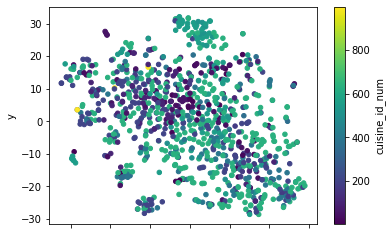

In [126]:
cronozero_rocks.plot.scatter(x='x', y='y', c='cuisine_id_num', colormap='viridis');

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not viridis

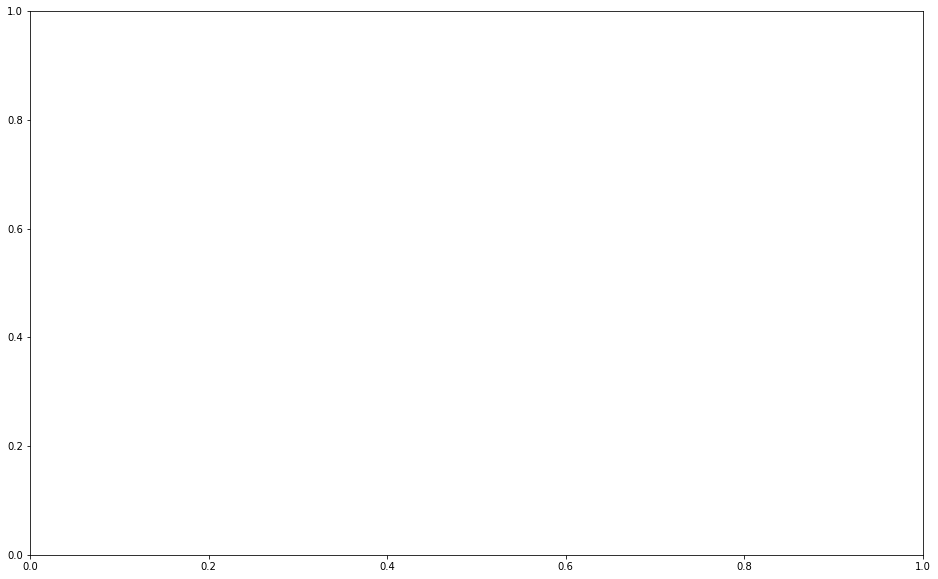

In [67]:
plt.figure(figsize=(16,10))
plt.scatter(x=vis_t_sne[:,0], y=vis_t_sne[:,1], c='viridis', alpha=0.3, cmap='viridis'); 
plt.colorbar()

In [ ]:
sheeeeeesh['cuisine_name']

In [ ]:
sheeeeeesh['cuisine_name'][49]